In [56]:
import pandas as pd
# pd.options.display.max_colwidth = 200

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

# Data overview

In [2]:
data = pd.read_csv('./DATA_MANY_TOPICS.csv')

In [3]:
data.dropna(inplace=True)

In [57]:
data.sample(5)

,text,title,topic,url
175495,лидерство спартак временный мол цска наверстывать зенит играть максимум завидовать вопрос глушаков вредитель наговаривать многие видеть спартак чемпион болеть страна приезжать гостевой сектор заби...,денис глушаков спартак переставать писать футбол умирать,14,http://www.sport-express.ru/football/rfpl/clubs/news/denis-glushakov-esli-o-spartake-perestanut-pisat-to-futbol-u-nas-prosto-umret-1061773/
4121,акция рбк актив онэксим ход торги московский биржа дорожать руб акция приводить данные торги мск темп рост котировка компания сокращаться акция дорожать руб акция группа онэксим михаил прохоров пр...,акция рбк дорожать из-за информация продажа актив онэксим,27,http://www.vedomosti.ru/technology/news/2016/07/04/647854-aktsii-rbk-dorozhali
30649,гендиректор blackberry джон чэн заявлять компания отказываться производство мобильный телефон бизнес оставаться убыточный зарабатывать смартфон заниматься бизнес цитировать reuters слово окончател...,blackberry отказываться производство смартфон,27,http://www.vedomosti.ru/technology/articles/2014/04/10/blackberry-mozhet-otkazatsya-ot-proizvodstva-smartfonov
19938,бывший акционер юкос арест дипломатический здание россия париж добиваться арест платеж провайдер пусковой услуга arianespace спутниковый оператор eutelsat адрес российский контрагент передавать рб...,бывший акционер юкос пытаться заблокировать транссибирский роялти air france рбк,6,http://www.vedomosti.ru/business/news/2015/12/21/621920-aktsioneri-yukosa
76972,группа депутат европарламент представлять политический сила ряд страна негативно относиться процесс европейский интеграция инициировать вынесение вотум недоверие президент еврокомиссия жан-клод юн...,евроскептик инициировать вотум недоверие президент еврокомиссия,21,https://lenta.ru/news/2014/11/19/juncker/


In [5]:
print('Number of news:', len(data))

Number of news: 179996


In [6]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


In [77]:
data.topic.value_counts()

14    11993
21    11849
17    11400
6     10022
27     7097
13     6592
24     5516
10     5308
18     5067
22     4878
2      4210
19     4165
31     4120
15     3993
20     3809
28     3561
1      3453
8      3316
9      2576
5      2464
12     2426
3      2235
26     2039
11     1835
16     1433
0      1225
4       939
23      903
29      882
25      696
30      528
7       466
Name: topic, dtype: int64

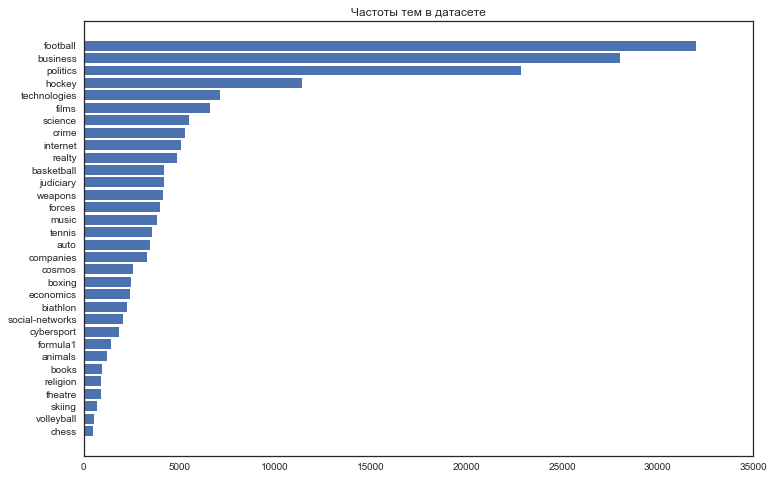

In [8]:
topics_freq = data.topic.value_counts(ascending=True)
plt.figure(figsize=(12,8))
plt.barh(range(len(topics_freq)), topics_freq.values)
plt.yticks(range(len(topics_freq)), topics_freq.index);
plt.xticks(np.arange(0, 35001, 5000));
plt.title('Частоты тем в датасете');

In [9]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [10]:
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс', 'редакция'])

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [11]:
with open('./stop_words/russian.txt') as file:
    for line in file:
        STOP_WORDS.add(Pipeline(get_lower, remove_punctuation, get_word_normal_form)(line))

with open('./stop_words/english.txt') as file:
    for line in file:
        STOP_WORDS.add(Pipeline(get_lower, remove_punctuation, get_word_normal_form)(line))

In [12]:
def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

In [13]:
TEXT_PIPELINE = Pipeline(remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [14]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 179996/179996 [02:53<00:00, 1037.48it/s]


CPU times: user 1min 56s, sys: 12.4 s, total: 2min 8s
Wall time: 2min 54s


In [15]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 179996/179996 [00:07<00:00, 24308.05it/s]

CPU times: user 6.36 s, sys: 244 ms, total: 6.6 s
Wall time: 7.43 s


In [16]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 248181


In [17]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 145473


In [18]:
top_k = 25
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 25 most frequent words:
1 россия 126825
2 компания 109441
3 сообщать 102767
4 российский 68778
5 матч 64084
6 слово 60845
7 заявлять 59558
8 отмечать 55033
9 команда 50830
10 млрд 50396
11 страна 49081
12 президент 48715
13 получать 48335
14 сша 47921
15 новый 46438
16 млн 42197
17 ранее 40887
18 руб 39542
19 чемпионат 37965
20 москва 37903
21 данный 37803
22 представитель 37247
23 составлять 36945
24 решение 35534
25 работа 35440


# Baseline

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

## Закодируем целевую переменную

In [20]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

In [61]:
data.drop(data[data.topic == 14].sample(20000).index, inplace=True)
data.drop(data[data.topic == 6].sample(18000).index, inplace=True)
data.drop(data[data.topic == 21].sample(11000).index, inplace=True)

In [63]:
data.topic.value_counts()

14    11993
21    11849
17    11400
6     10022
27     7097
13     6592
24     5516
10     5308
18     5067
22     4878
2      4210
19     4165
31     4120
15     3993
20     3809
28     3561
1      3453
8      3316
9      2576
5      2464
12     2426
3      2235
26     2039
11     1835
16     1433
0      1225
4       939
23      903
29      882
25      696
30      528
7       466
Name: topic, dtype: int64

## Разделим данные на train и validation

In [64]:
trainX = data.text + ' ' + data.title
trainX = np.swapaxes(np.vstack([trainX.values, data.url.values]), 0, 1)
trainY = data.topic.values

In [65]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)

## Вычислим tf-idf

In [66]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,1), lowercase=False).fit(trainX[:,0])

CPU times: user 19.6 s, sys: 537 ms, total: 20.1 s
Wall time: 20.4 s


In [67]:
len(tfidf_vectorizer.vocabulary_)

60931

In [68]:
X_train_tf = tfidf_vectorizer.transform(X_train[:,0])
X_test_tf = tfidf_vectorizer.transform(X_test[:,0])

## Обучим SVM

In [69]:
clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)

In [70]:
%%time
clf.fit(X_train_tf, y_train)

CPU times: user 22 s, sys: 621 ms, total: 22.6 s
Wall time: 23.2 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [71]:
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

F1 score: 0.88129377355
Accuracy: 0.878648311662


## Построим нормализованную матрицу потерь

In [72]:
cm = confusion_matrix(y_test, clf_prediciton)
cm = np.round(cm / cm.sum(axis=1)[:, np.newaxis], 2)

In [73]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(cm, columns=classes, index=classes)

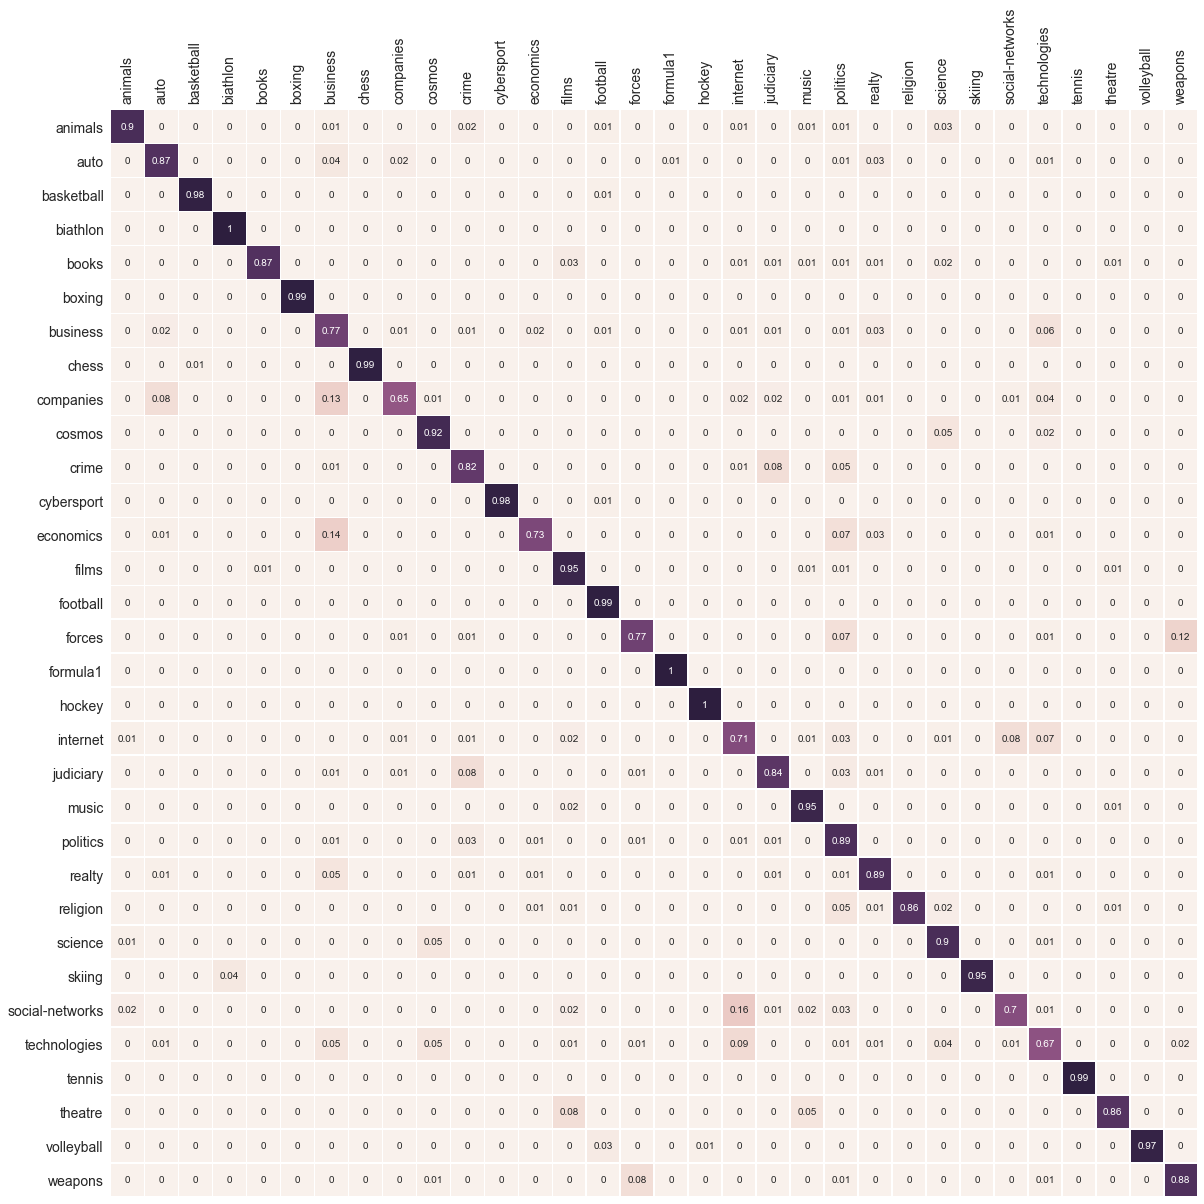

In [74]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

## Посмотрим на ошибки классификации

In [ ]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['Техника'])[0] and pred == le.transform(['Недвижимость'])[0]:
        print(X_test[i][1])

## Выведем слова с максимальным весом внутри каждого класса

In [75]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    kek = []
    cols = ['top' + str(i+1) for i in range(k)]
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        kek.append([feature_names[j] for j in top_K])
#         print('%s: %s' % (class_label, ' '.join(feature_names[j] for j in top_K)))
    return pd.DataFrame(kek, index=class_labels, columns=cols)

In [76]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
animals,видеозапись,хозяин,вольер,утка,животный,питомец,зоопарк,просматривать,животное,кличка
auto,автозавод,автокомпонент,мобиль,авторынок,камаз,осаго,автоваз,автопроизводитель,автомобиль,автопром
basketball,подбор,баскетболистка,уникс,рфб,евробаскет,центровой,баскетбол,баскетболист,нба,евролига
biathlon,домрачева,касперович,фуркад,шипулин,биатлонистка,биатлон,сбр,ibu,хохфильцен,биатлонист
books,роман,литература,библиотека,книга,произведение,комикс,писательница,поэт,литературный,писатель
boxing,ринг,мма,лебзяк,поединок,алоян,поветкин,боец,бой,бокс,боксер
business,ржд,мск,mcdonald,нефтепродукт,rusal,читать,туроператор,ритейлер,formula,оао
chess,костенюк,карякина,магнус,илюмжинов,шахматист,карлсен,фид,карякин,шахматы,шахматный
companies,глава,процентный,го,настоящий,кубометр,миллиард,релиз,тонна,service,ретейлер
cosmos,спутник,скопление,солнечный,космический,ровер,космос,астрофизик,марс,светить,астронавт
